# Data Augmentation
- O objetivo deste notebook é explorarmos um pouco sobre data augmentation
- Para isso, vamos explorar os seguintes módulos:
    1. [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)
    2. [imgaug](https://github.com/aleju/imgaug)
        - **Importante:** a biblioteca ficou depreciada e parou de ser mantida. Aqui existe um fork atualizado: https://github.com/life-ufes/imgaug-life
    
- Também vamos falar um pouco sobre os modulos `Functional` do Pytorch

In [1]:
import torchvision.transforms as transforms
import torchvision.transforms.functional as transF
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from PIL import Image

## Usando o `torchvision.transforms`
- Esse é o módulo oficial do Pytorch para aplicarmos transformações e augmentation em imagens
- As transformações podem ser encadeadas (usando `Compose`) e a maioria das classes tem equivalente na versão `functional`
- A maioria das transformações aceitam PIL images e tensores
    - Algumas são apenas para PIL e outras apenas para tensores
    - Tem que consultar a documentação quando for usar

#### Vamos carregar uma imagem com PIL para aplicarmos algumas transformações

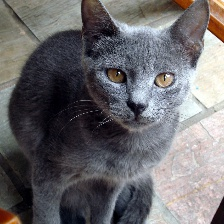

In [2]:
image = Image.open("./felinos/test/cat/50.jpg")
image # como é um PIL, o jupyter ja plota como imagem

- Vamos aplicar um resize usando o `transforms`
    - https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize

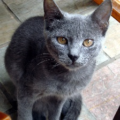

In [3]:
res_op = transforms.Resize((120, 120))
res_op(image)

- Perceba que a gente instanciou um objeto da classe resize e depois chamou ele
- Isso é o padrão para criarmos composições de operações. Porém, para fazermos testes rápidos ou fora de composições, podemos usar o functional
    - Nesse caso, vamos usar uma função ao invés de uma classe
    - Como disse antes, quase todas as classes tem uma função correspondente

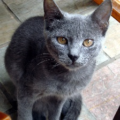

In [4]:
transF.resize(image, (120, 120))

- Aplicando outras operações

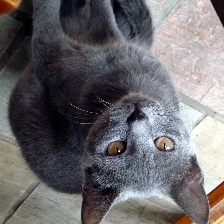

In [5]:
transF.vflip(image)

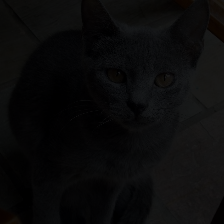

In [6]:
transF.adjust_brightness(image, 0.1)

- E se quiseremos aplicar varias transformações?
    - Uma opção seria ficar pegando o resultado da operação anterior e aplicar na próxima
    - Porém, é mais fácil utilizar um `Compose`
        - E para isso, temos que usar as classes
- Também vamos adicionar aleatoriedade

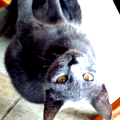

In [7]:
many_trans = transforms.Compose([
                transforms.Resize((120, 120)),
                transforms.RandomVerticalFlip(p=0.6),
                transforms.ColorJitter(brightness=0.4, contrast=0.3)
            ])

many_trans(image)

- Após aplicar os processamentos desejados, o padrão é transformar a imagem para tensor e também podemos aplicar uma normalização
- Essa normalização pode ser entre 0 e 1
- Porém, como muitas das vezes usamos um modelo pré-treinado na imageNet, usamos a mesma normalização que é usada la
    - No caso, é uma normalização de média zero e desvio padrao 1 (Z-norm)
    - Os valores são: média: `[0.485, 0.456, 0.406]` e desvio: `[0.229, 0.224, 0.225]`

In [8]:
many_trans = transforms.Compose([
                transforms.Resize((120, 120)),
                transforms.RandomVerticalFlip(p=0.6),
                transforms.ColorJitter(brightness=0.4, contrast=0.3),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

many_trans(image)

tensor([[[ 0.5707,  0.0227, -0.3198,  ...,  1.9920,  1.9920,  1.9920],
         [ 0.6906,  0.4508, -0.2856,  ...,  1.9920,  1.9920,  1.9920],
         [ 0.7077,  0.6734,  0.2111,  ...,  1.9920,  1.9920,  1.9920],
         ...,
         [ 0.0056,  0.0056,  0.1083,  ..., -1.4500, -1.3987, -1.4500],
         [ 0.0569,  0.1939,  0.4166,  ..., -1.3815, -1.4158, -1.4500],
         [ 0.1939,  0.4679,  0.9303,  ..., -1.3815, -1.4158, -1.4500]],

        [[ 0.7304,  0.1877, -0.2150,  ...,  2.0609,  2.1660,  2.1660],
         [ 0.8354,  0.5728, -0.1625,  ...,  2.1660,  2.1485,  2.1660],
         [ 0.8529,  0.8179,  0.3277,  ...,  2.1660,  2.1660,  2.1660],
         ...,
         [-1.4405, -1.3704, -1.3004,  ..., -1.5105, -1.4930, -1.5455],
         [-1.3704, -1.2304, -1.0203,  ..., -1.4930, -1.5105, -1.5280],
         [-1.0203, -0.8277, -0.4076,  ..., -1.5105, -1.4930, -1.5105]],

        [[ 0.8448,  0.3045, -0.0964,  ...,  1.0191,  1.7685,  2.3786],
         [ 0.9319,  0.6879, -0.0615,  ...,  1

- **Importante**: se você possui um batch de images (ex: `[10, 3, 120, 120]`), ao chamar as operações dentro do `Compose`, ele aplica para todas as imagens no batch de maneira individual

## Imgaug
- Usar transforms é interessante e pode resolver a maioria dos casos
- Porém, existem outras bibliotecas de augmentation que fornecem muito mais operações
- Uma delas é a [imgaug](https://github.com/aleju/imgaug)
- A ideia é a mesma, só muda um pouquinho os comandos e temos acesso mais transformações transformações para aplicarmos em uma imagem
- E a lib usa OpenCV por trás dos panos

In [9]:
from imgaug import augmenters as iaa
import numpy as np

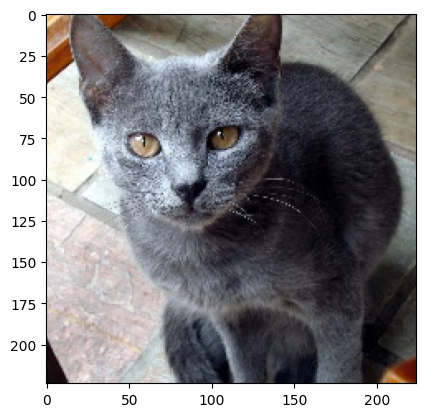

In [10]:
my_aug = iaa.Sequential([
            iaa.Sometimes(0.25, iaa.Affine(scale={"x": (1.0, 2.0), "y": (1.0, 2.0)})),
            iaa.Resize((224, 224)),
            iaa.Fliplr(0.5),
            iaa.Flipud(0.2),
            iaa.Sometimes(0.25, iaa.Affine(rotate=(-120, 120), mode='symmetric')),
            iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),

            # noise
            iaa.Sometimes(0.1,
                          iaa.OneOf([
                              iaa.Dropout(p=(0, 0.05)),
                              iaa.CoarseDropout(0.02, size_percent=0.25)
                          ])),

            iaa.Sometimes(0.25,
                          iaa.OneOf([
                              iaa.Add((-15, 15), per_channel=0.5), # brightness
                              iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
                          ])),

        ])

# Atenção aqui que se for mais de uma imagem (no caso de batch de imagens por exemplo), precisamos passar
# images= ao invés de image=
res = my_aug(image=np.asarray(image))
plt.imshow(res)

- Podemos usar o método `show_grid()` pra gerar varias instancias do augmentation pra gente ter uma noção do que está acontencendo

AttributeError: 'FigureCanvasAgg' object has no attribute 'set_window_title'

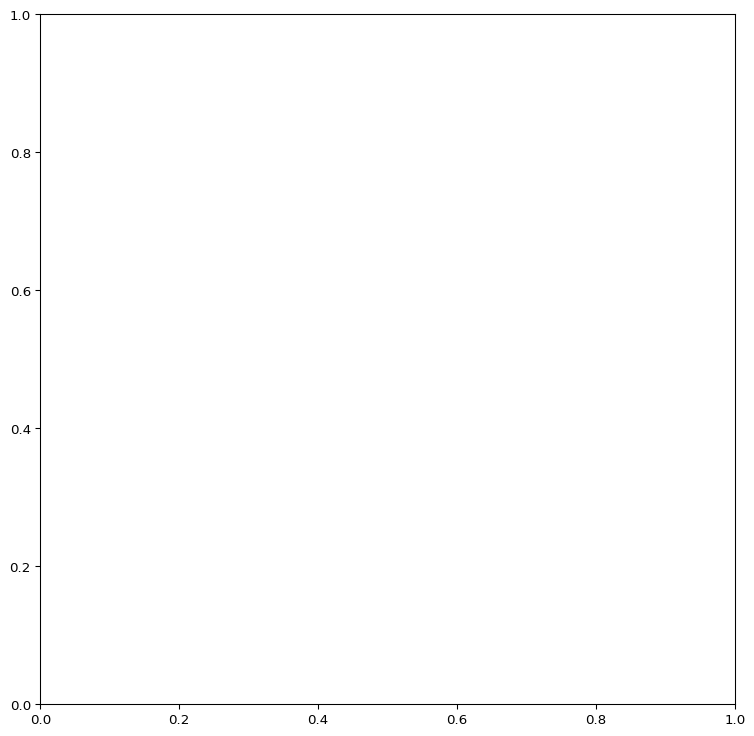

In [11]:
my_aug.show_grid([np.asarray(image)], cols=4, rows=4)

- **Importante**: as operações da `imgaug` são feitas em cima de numpy arrays. Precisamos converter pra tensor e fazer a normalização no final dela
- Para isso, podemos usar o `torchvision.transform`
- Na verdade, podemos incluir a sequência do `imgaug` dentro do `compose` usando o método `augment_image`
    - Só ter atenção para passarmos um Numpy array como entrada

#### Juntando `imgaug` e `torchvision.transform`

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


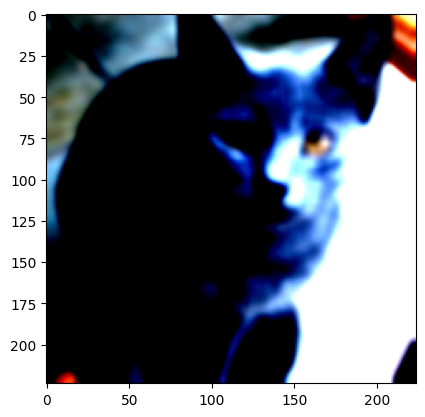

In [12]:
my_trans = transforms.Compose([
                np.array,
                my_aug.augment_image,
                np.copy,
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

res = my_trans(image)
plt.imshow(res.permute(1, 2, 0))

- Como o augmentation é só durante o treino, precisamos ter um transformador apenas para dados que vão ser avaliados

In [13]:
my_trans_eval = transforms.Compose([             
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

## Vamos usar o transform com o `my_dataset`
- Vamos usar os resultados do notebook anterior para carregar os dados da base de felinos novamente

In [14]:
class MyDataset (torch.utils.data.Dataset):
    """
    Esse dataset recebe uma lista de path de imagens, uma lista de labels correspondentes e (opcional) transformações pata aplicar nas imagens
    quando elas forem carregadas
    """

    def __init__(self, imgs_path, labels, my_transform=None):
        """
        imgs_path: list ou tuple
            Uma lista ou tupla com os paths para todas as imagens
        labels: lista ou tuple
            Uma lista ou tupla com o label de todas as imagens. Obviamente, precisa dar match com o os paths
        my_transform: None ou torchvision.transforms
            Uma sequência de transformadores para aplicar nos dados. Se for None, ele apenas transforma em tensor
        """

        super().__init__()
        self.imgs_path = imgs_path
        self.labels = labels
        
        # se my_transform for None, precisamos garantir que a imagem PIL seja transformada em Tensor para nao 
        # obtermos um erro quando usarmos o dataloader (ver aulas passadas)        
        if my_transform is not None:
            self.transform = my_transform
        else:
            self.transform = transforms.ToTensor()


    def __len__(self):     
        """
        Sobrecarga do método len para obtermos o tamanho do dataset. Não é obrigatório implementar
        """
        return len(self.imgs_path)


    def __getitem__(self, item):        
        """
        Esse método obtém uma imagem e um label cada vez que iteramos no Dataset. Ele também aplica a transformação
        na imagem. É obrigatório sua implementação
        
        item: int 
            Um indice no intervalo [0, ..., len(img_paths)-1]
        
        return: tuple 
             Uma tupla com a imagem, label e ID da imagem correspondentes ao item
        """

        # Aqui usamos PIL para carregar as imagens
        image = Image.open(self.imgs_path[item]).convert("RGB")

        # Aplicando as transformações
        image = self.transform(image)

        # Obtendo o ID da imagem
        img_id = self.imgs_path[item].split('/')[-1].split('.')[0]

        if self.labels is None:
            labels = []
        else:
            labels = self.labels[item]

        return image, labels, img_id

#### Preparando dados para criarmos um dataset

In [15]:
from glob import glob
import os

In [26]:
train_data_path = "./felinos/train"
test_data_path = "./felinos/test"

In [27]:
labels_name = glob(os.path.join(train_data_path, "*"))
labels_name = [l.split(os.path.sep)[-1] for l in labels_name]
labels_name

['tiger', 'cat', 'leopard', 'lion']

In [28]:
def get_paths_and_labels(path, lab_names):
    imgs_path, labels = list(), list()
    lab_cnt = 0
    for lab in lab_names:    
        paths_aux = glob(os.path.join(path, lab, "*.jpg"))
        
        # Atualizando os labels e imgs_paths
        labels += [lab_cnt] * len(paths_aux)
        imgs_path += paths_aux
        
        lab_cnt += 1
        
    return imgs_path, labels

- Obtendo paths e labels para cada partição

In [29]:
train_imgs_paths, train_labels = get_paths_and_labels(train_data_path, labels_name)
test_imgs_paths, test_labels = get_paths_and_labels(test_data_path, labels_name)

#### Instanciando os datasets

In [30]:
train_dataset = MyDataset(train_imgs_paths, train_labels, my_transform=my_trans)
test_dataset = MyDataset(test_imgs_paths, test_labels, my_transform=my_trans_eval)
train_dataset

### Criando um Dataloader
- Agora, podemos criar um [dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) como fizemos nas últimas duas aulas

In [31]:
batch_size = 30
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True)

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True)

## (Re)criando uma CNN
- Vamos criar uma CNN para classificar os felinos
- Para facilitar o projeto, vamos criar uma função que calcula o tamanho da saída

In [32]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, stride=2), # 109
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # 54
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=7, stride=2), # 24
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=4)) # 6
        self.fc = nn.Linear(576, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)        
        out = self.layer2(out)
        # Fazendo a operação de flatten        
        out = out.reshape(out.size(0), -1)        
        out = self.fc(out)
        return out

- Agora podemos instanciar o nosso modelo:

In [33]:
model = ConvNet()
model

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 16, kernel_size=(7, 7), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=576, out_features=4, bias=True)
)

- Agora podemos determinar nossa função de custo e otimizador
- Para esse notebook vamos aproveitar o que já fizemos no anterior

In [34]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  

- Agora vamos fazer nosso loop de treinamento
- Agora, vamos mandar nosso modelo para GPU se ela estiver disponível
- **Novo**: vamos criar nosso pipeline de checkpoints

In [35]:
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Movendo o modelo para o device alvo
model.to(device)

best_loss = np.inf

for epoch in range(num_epochs):
    
    loss_epoch, cnt = 0, 0
    for k, (batch_images, batch_labels, id_img) in enumerate(train_dataloader):  
        
        # Aplicando um flatten na imagem e movendo ela para o device alvo
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        
        # Fazendo a forward pass
        # observe que o modelo é agnóstico ao batch size
        outputs = model(batch_images)
        loss = loss_func(outputs, batch_labels)
        loss_epoch += loss.item()
        
        # Fazendo a otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
        cnt += 1
        
    loss_epoch = loss_epoch/cnt
        
    # Salvando o checkpoint da última época
    checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_func,
            'loss_val': loss_epoch
    }        
    torch.save(checkpoint, "last_checkpoint.pth")

    # Salvando a mellhor execução
    nb = "No"
    if loss_epoch < best_loss:
        nb = "Yes"
        best_loss = loss_epoch
        torch.save(checkpoint, "best_checkpoint.pth")
        
    
    print (f"- Epoch [{epoch+1}/{num_epochs}] | Loss: {loss_epoch:.4f} | New best? {nb}")                  

- Epoch [1/30] | Loss: 1.5474 | New best? Yes
- Epoch [2/30] | Loss: 1.3842 | New best? Yes
- Epoch [3/30] | Loss: 1.3070 | New best? Yes
- Epoch [4/30] | Loss: 1.2479 | New best? Yes
- Epoch [5/30] | Loss: 1.2418 | New best? Yes
- Epoch [6/30] | Loss: 1.2418 | New best? No
- Epoch [7/30] | Loss: 1.2467 | New best? No
- Epoch [8/30] | Loss: 1.1820 | New best? Yes
- Epoch [9/30] | Loss: 1.1964 | New best? No
- Epoch [10/30] | Loss: 1.1663 | New best? Yes
- Epoch [11/30] | Loss: 1.1359 | New best? Yes
- Epoch [12/30] | Loss: 1.1447 | New best? No
- Epoch [13/30] | Loss: 1.1193 | New best? Yes
- Epoch [14/30] | Loss: 1.1112 | New best? Yes
- Epoch [15/30] | Loss: 1.1011 | New best? Yes
- Epoch [16/30] | Loss: 1.0906 | New best? Yes
- Epoch [17/30] | Loss: 1.0521 | New best? Yes
- Epoch [18/30] | Loss: 1.0830 | New best? No
- Epoch [19/30] | Loss: 1.0264 | New best? Yes
- Epoch [20/30] | Loss: 1.0862 | New best? No
- Epoch [21/30] | Loss: 1.0464 | New best? No
- Epoch [22/30] | Loss: 0.984

### Fazendo inferência no conjunto de teste
- A inferência é basicamente igual a do notebook anterior

In [36]:
with torch.no_grad():
    correct, total = 0, 0
    for images, labels, img_id in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total}%")

Accuracy: 58.5%
